## <font color=Grey>**Data Mind Classes**</font> 
### <font color=Black>Class 5: Validation</font> 

<div class="alert alert-block alert-info">

*In this step, you will learn to use model validation to measure the quality of your model. Measuring model quality is the key to iteratively improving your models.*

# What is Model Validation
You've built a model. But how good is it?

You'll need to answer this question for almost every model you ever build. In most (though not necessarily all) applications, the relevant measure of model quality is predictive accuracy. In other words, will the model's predictions be close to what actually happens.

Some people try answering this problem by making predictions with their *training data*. They compare those predictions to the actual target values in the *training data*. This approach has a critical shortcoming, which you will see in a moment (and which you'll subsequently see how to solve).

Even with this simple approach, you'll need to summarize the model quality into a form that someone can understand. If you have predicted and actual home values for 10000 houses, you will inevitably end up with a mix of good and bad predictions. Looking through such a long list would be pointless.

There are many metrics for summarizing model quality, but we'll start with one called Mean Absolute Error (also called MAE). Let's break down this metric starting with the last word, error.

The prediction error for each house is: <br>
error=actual−predicted
 
So, if a house cost \$150,000 and you predicted it would cost \$100,000 the error is \$50,000.

With the MAE metric, we take the absolute value of each error. This converts each error to a positive number. We then take the average of those absolute errors. This is our measure of model quality. In plain English, it can be said as

On average, our predictions are off by about X

In [1]:
# Data Loading Code Hidden Here
import pandas as pd

# Load data
melbourne_file_path = 'C:/Users/ADMIN/_Data Mind/Class 5/Melb hoising data/melb_data.csv'
melbourne_data = pd.read_csv(melbourne_file_path) 
# Filter rows with missing values
filtered_melbourne_data = melbourne_data.dropna(axis=0)
# Choose target and predictors
y = filtered_melbourne_data.Price
melbourne_predictors = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 
                        'YearBuilt', 'Lattitude', 'Longtitude']
X = filtered_melbourne_data[melbourne_predictors]

We then create the Decision tree model with this code:

In [2]:
from sklearn.tree import DecisionTreeRegressor
# Define model
melbourne_model = DecisionTreeRegressor()
# Fit model
melbourne_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

The calculation of mean absolute error in the Melbourne data is

In [3]:
from sklearn.metrics import mean_absolute_error

predicted_home_prices = melbourne_model.predict(X)
mean_absolute_error(y, predicted_home_prices)

434.71594577146544

# The Problem with "In-Sample" Scores

The measure we just computed can be called an "in-sample" score. We used a single set of houses (called a data sample) for both building the model and for calculating it's MAE score. This is bad.

Imagine that, in the large real estate market, door color is unrelated to home price. However, in the sample of data you used to build the model, it may be that all homes with green doors were very expensive. The model's job is to find patterns that predict home prices, so it will see this pattern, and it will always predict high prices for homes with green doors.

Since this pattern was originally derived from the training data, the model will appear accurate in the training data.

But this pattern likely won't hold when the model sees new data, and the model would be very inaccurate (and cost us lots of money) when we applied it to our real estate business.

Even a model capturing only happenstance relationships in the data, relationships that will not be repeated when new data, can appear to be very accurate on in-sample accuracy measurements.

# Example

Models' practical value come from making predictions on new data, so we should measure performance on data that wasn't used to build the model. The most straightforward way to do this is to exclude some data from the model-building process, and then use those to test the model's accuracy on data it hasn't seen before. This data is called **validation data**.

The scikit-learn library has a function train_test_split to break up the data into two pieces, so the code to get a validation score looks like this:

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.33,random_state = 0)
# Define model
melbourne_model = DecisionTreeRegressor()
# Fit model
melbourne_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = melbourne_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

251117.3193154034


# k fold cross validation

In [5]:
### k fold cv
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

folds = 5
kf = KFold(n_splits=folds)  ### we do 5 fold cv
kf.get_n_splits(X)

error = []   ### to keep track of MAE
k = 0
for train_index, test_index in kf.split(X):   #### creates index of test and train for each split
    #print("TRAIN:", train_index, "TEST:", test_index)
    k+=1
    X_train, X_val = X.loc[train_index], X.loc[test_index]
    y_train, y_val = y.loc[train_index], y.loc[test_index]
    #print(X_train.isnull().any())
    X_train,y_train,X_val,y_val = X_train.fillna(0),y_train.fillna(0),X_val.fillna(0),y_val.fillna(0)
    #print(X_train.isnull().any())
    melbourne_model = DecisionTreeRegressor()
    melbourne_model.fit(X_train, y_train)
    val_predictions = melbourne_model.predict(X_val)
    print("Fold:{} : MAE:{}".format(k,mean_absolute_error(y_val, val_predictions)))
    error.append({'fold':k,'MAE':mean_absolute_error(y_val, val_predictions)})
    print('*'*50)
    
print("Average MAE across all {} fold: {}".format(folds,np.mean([i['MAE'] for i in error])))

Fold:1 : MAE:195696.33306451613
**************************************************
Fold:2 : MAE:176738.53914447135
**************************************************
Fold:3 : MAE:157940.88458434222
**************************************************
Fold:4 : MAE:153474.08474576272
**************************************************
Fold:5 : MAE:131672.6795803067
**************************************************
Average MAE across all 5 fold: 163104.50422387983


C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [6]:
import matplotlib.pyplot as plt
plt.plot([i['fold'] for i in error],[i['MAE'] for i in error],'bo')
plt.title('Cross validation error across folds')
plt.show()

# Stratified k fold cross validation

In [7]:
### stratified k fold using iris dataset
from sklearn import datasets
iris = datasets.load_iris()
X,y = (iris.data),(iris.target)

In [8]:
###drop other categories to keep only 2 categories for our logistic regression example
X = X[iris.target != 2]
y = y[iris.target != 2]

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

folds = 5
kf = StratifiedKFold(n_splits=folds)  ### we do 5 fold stratified cv
kf.get_n_splits(X,y)
X = X[]
error = []   ### to keep track of MAE
k = 0
print("RATIO POS:NEG in original: {}:1".format(np.sum(y==1)/np.sum(y==0)))
print('*'*50)
for train_index, test_index in kf.split(X,y):   #### creates index of test and train for each split
    k+=1
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]   
    
    print("RATIO POS:NEG: {}:1".format(np.sum(y_train==1)/np.sum(y_train==0)))

    iris_model = LogisticRegression()
    iris_model.fit(X_train, y_train)
    val_predictions = iris_model.predict_proba(X_val)
    print("Fold:{} : log_loss:{}".format(k,log_loss(y_val, val_predictions)))
    error.append({'fold':k,'log_loss':log_loss(y_val, val_predictions)})
    print('*'*50)

print("Average log_loss across all {} fold: {}".format(folds,np.mean([i['log_loss'] for i in error])))

RATIO POS:NEG in original: 1.0:1
**************************************************
RATIO POS:NEG: 1.0:1
Fold:1 : log_loss:0.028149993249989857
**************************************************
RATIO POS:NEG: 1.0:1
Fold:2 : log_loss:0.02366737702165452
**************************************************
RATIO POS:NEG: 1.0:1
Fold:3 : log_loss:0.03231732297404748
**************************************************
RATIO POS:NEG: 1.0:1
Fold:4 : log_loss:0.025501362589796562
**************************************************
RATIO POS:NEG: 1.0:1
Fold:5 : log_loss:0.04192288869034439
**************************************************
Average log_loss across all 5 fold: 0.03031178890516656


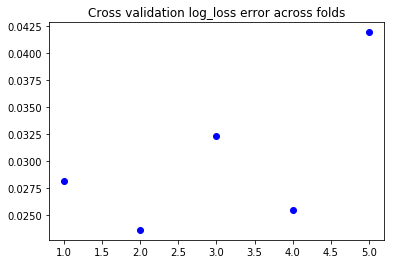

In [11]:
import matplotlib.pyplot as plt
plt.plot([i['fold'] for i in error],[i['log_loss'] for i in error],'bo')
plt.title('Cross validation log_loss error across folds')
plt.show()

# Exercise:

**Use Wine dataset to (assume we are predicting wine quality):** [Wine Dataset Link](https://archive.ics.uci.edu/ml/datasets/wine+quality)
    - Create 80-20 index split for train test
    - Create 5 fold CV indexes
    - Create 5 fold stratified CV indexes

# For Time Series:
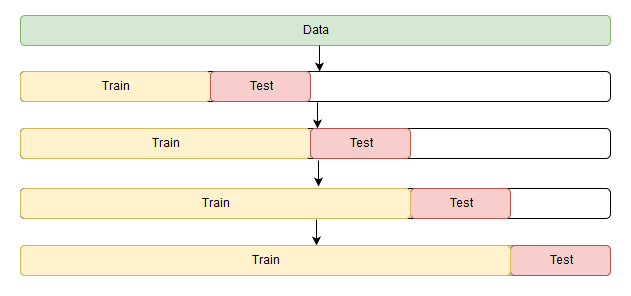
- In case of time series data, the valildation is not straight forward since there is an element of time involved.
- Instead of randomly sampling data points for validation, we reserve last/most recent N% data points for validation set
- For k fold we incrementaly take random samples of the original dataset and consider last N% out of those for validation

# Final model build
- Cross Validation is used only to understand the 'real' model performance and choose the best models
- Eg: in case of Linear Regression if we have 15 variables, then we can build 15 regressions with stepwise incremental variables strating from Variable 1 to Variable 15
    - In case case we measure K fold CV perforamnce of each of our 15 models
    - We pick the model with best performance
    - Rebuild the best model (using same parameters, variables in our case) on entire dataset and report the CV performance as the 'expected' performance
    - k fold leads to using the entire dataset for model building, while the 80-20 approach leads to throwing away 20% data
    - Standard libraries have both hyperparameters tuning and CV built in, so we dont have to write our own for loops as shown above

# Question

- How to choose value of k? - Usually 5 or 10 fold CV is best